# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur adjoint au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>

# Devoir 6 - Régression bayésienne ( 15 points )

Le devoir concerne les notions de la régression linéaire bayésienne vues au Chapitre 7 du cours. 

## Devoir effectué par

NOM, PRÉNOM - MATRICULE

Jalbert, Jonathan - N6MAA10816

**Déclaration d’intégrité relative au plagiat**

Nous certifions sur l’honneur :
- Que les résultats décrits dans ce rapport sont l’aboutissement de notre travail.
- Que nous sommes les auteurs de ce rapport.
- Que nous n'avons pas utilisé des sources ou résultats tiers sans clairement les citer et les référencer selon les règles bibliographiques préconisées.

Nous déclarons que ce travail ne peut être soupçonné de plagiat.



# Contexte : Le valeur des diamants en fonction de leurs caractéristiques

Dans ce devoir, on s'intéresse à la valeur des diamants en fonctions de plusieurs caractéristiques phyiques. Le jeux de données contient les variables suivantes :

- Price : le prix du diamant en dollars américains
- Carat : le poids du diamant
- X : la longueur du diamant
- Y : la largeur du diamant
- Z : la profondeur du diamant
- Depth : la profondeur realtive du diamant ( z / mean(x, y) )
- Table : la largeur du sommet relativement relativement à la plus grande largeur


# Consignes

- Le devoir doit être remis sur Moodle **avant 23h59 le mardi 17 novembre 2020.** Les retards ne seront pas tolérés car le solutionnaire sera publié dès mercredi.
- Le devoir a une pondération de 7.5%.
- Écrivez vos noms et vos matricules dans l'espace prévu à cet effet de cette cellule.
- Vous pouvez compléter le devoir en équipe de deux personnes. Dans ce cas, un seul fichier par équipe doit être remis. Pour vous aider à trouver un coéquipier, le canal de discussion *#trouver_un_coéquipier* a été créé sur Slack.
- Le devoir doit être complété dans le présent calepin Jupyter en ajoutant autant de cellules de texte et de code que nécessaires. Vous remettrez ce fichier en format *.ipynb*. Le nom du fichier doit être *matricule1_matricule2_devoir2.ipynb*.
- N'utilisez que les librairies introduites à la cellule suivante.

## Chargement des libairies

In [17]:
using CSV              # Pour la manipulation des fichiers CSV
using DataFrames       # Pour l'utilisation des DataFrame
using Distributions    # Pour l'utilisation des lois de probabilités
using Gadfly           # Pour la création de figures
using LinearAlgebra    # Pour l'utilisation de fonctions d'algèbre linéaire
import Random          # Pour l'utilisation des générateurs de nombres aléatoires
using Statistics       # Pour l'utilisation de fonctions statistiques de bases  
import StatsBase       # Pour la standardisation des variables

## Chargement des données

On prend la racine cubique du prix pour linéariser la relation

In [18]:
data = CSV.read("diamondprices.csv")
data[!, :Price] = data[:,:Price].^(1/3)
first(data, 5)

,Price,Carat,X,Y,Z,Depth,Table
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,10.9641,0.43,4.86,4.9,2.99,61.3,56.0
2,9.91257,0.34,4.53,4.55,2.78,61.2,56.0
3,11.1253,0.45,4.96,5.0,3.04,61.0,57.0
4,9.6226,0.31,4.38,4.41,2.73,62.1,54.0
5,9.55006,0.31,4.38,4.42,2.68,61.1,57.0


## Partitionnement du jeu de données en ensemble d'entraînement et de validation

In [19]:
Random.seed!(3302)

ntrain = round(Int, .8*nrow(data))

train_id = sample(1:nrow(data), ntrain, replace=false, ordered=true)
valid_id = setdiff(1:nrow(data), train_id)

train = data[train_id, :]
valid = data[valid_id, :]

,Price,Carat,X,Y,Z,Depth,Table
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,9.81666,0.33,4.47,4.49,2.77,61.8,54.0
2,9.94638,0.33,4.45,4.47,2.75,61.7,55.0
3,9.84425,0.32,4.41,4.43,2.73,61.8,55.0
4,9.6226,0.31,4.37,4.4,2.64,60.2,59.0
5,14.0946,0.61,5.43,5.45,3.39,62.3,56.0
6,9.71884,0.32,4.42,4.45,2.76,62.2,54.0
7,20.6994,1.01,6.44,6.47,3.97,61.5,58.0
8,10.1088,0.37,4.6,4.64,2.88,62.4,56.0
9,20.8278,1.08,6.62,6.59,4.05,61.3,57.0


## Standardisation des variables de l'ensemble d'entraînement

Une fois les variables standardisées, l'ordonnée à l'origine n'est plus nécessaire.

In [20]:
# Estimation des paramètres de la standardisation
ty = StatsBase.fit(StatsBase.ZScoreTransform, train.Price)

# Standardisation des variables
y = StatsBase.transform(ty, train.Price)

# Estimation des paramètres de la standardisation
tx = StatsBase.fit(StatsBase.ZScoreTransform, Matrix{Float64}(train[:,2:end]), dims=1)

# Standardisation des variables
X = StatsBase.transform(tx, Matrix{Float64}(train[:,2:end]));

# Exercice 1 : Loi *a priori* non informative

Utilisez les 6 variables explicatives pour modéliser la valeur des diamants (:Price) avec une modèle de régression linéaire bayésien. 

Pour l'exercice 1, utilisez la loi *a priori* non informative du modèle de régression linéaire bayésien pour répondre aux questions suivantes.

### (a) Calculez les estimations ponctuelles des paramètres du modèle de régression linéaire.

In [21]:
n = length(y)
m = size(X,2)

β̂ = X\y

e = y - X*β̂

s² = e'e/(n-m)

println("β̂ = ", β̂)
println("σ̂² = ", s²)

β̂ = [0.8581761390666832, 0.8392222372429237, -0.8414545215747952, 0.14313261647257286, -0.008045308586384503, -0.006822291181861755]
σ̂² = 0.005933013379501185


### (b) Calculez un intervalle de crédibilité à 95 % pour le coefficient de régression associé au poids.

Intervalle de crédibilité = [0.7354205648202394, 0.980931713313127]


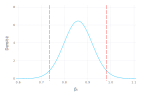

In [22]:
Σ = inv(X'X)
pd = LocationScale(β̂[1], sqrt(s²*Σ[1,1]), TDist(n-m))

α = 0.05

println("Intervalle de crédibilité = ", quantile.(pd, [α/2 , 1-α/2]))

plot(x->pdf(pd,x), .5, 1.5,
    xintercept = quantile.(pd, [α/2 , 1-α/2]), Geom.vline(style=:dash,color="red"),
    Guide.xlabel("β₁"), Guide.ylabel("Densité"),
    Coord.cartesian(xmin=.6, xmax=1.1))

### (c) Déterminez si la profondeur possède une influence significative sur la valeur des diamants.

Intervalle de crédibilité = [-0.1020397518489961, 0.08594913467622707]


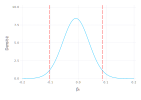

In [23]:
pd = LocationScale(β̂[5], sqrt(s²*Σ[5,5]), TDist(n-m))

α = 0.05

println("Intervalle de crédibilité = ", quantile.(pd, [α/2 , 1-α/2]))

plot(x->pdf(pd,x), -.2, .2,
    xintercept = quantile.(pd, [α/2 , 1-α/2]), Geom.vline(style=:dash,color="red"),
    Guide.xlabel("β₅"), Guide.ylabel("Densité"))

Puisque la valeur 0 est incluse dans l'intervalle de crédibilité, on peut conclure que la profondeur n'est pas significative.

**Note:** On peut toutefois noter que l'intervalle est peut-être exagérément large en raison de la multicolinéarité.

# Exercice 2 : Régression ridge

Utilisez les six variables explicatives pour modéliser la valeur des diamants mais, cette fois-ci, en utilisant le modèle de la régression ridge.

### (a) Spécifier l'hyperparamètre λ en minimisant le rmse sur l'échantillon de validation


In [24]:
df = DataFrame(λ = Float64[], β₁=Float64[], β₂=Float64[], β₃=Float64[], β₄=Float64[], β₅= Float64[], 
    β₆=Float64[], rmse = Float64[])

# Tansformation des variables explicatives de l'échantillon de validation
X_valid = StatsBase.transform(tx, Matrix{Float64}(valid[:,2:end]));

for λ in 0:.001:5

    # Estimation des coefficients de régression ridge
    β̂ = (X'X + λ*I)\X'y
    
    # Prédictions retransformées dans l'espaces originales
    ŷ = StatsBase.reconstruct(ty, X_valid*β̂)
    
    # Calcul du rmse
    rmse = StatsBase.rmsd(ŷ, valid.Price)
    
    push!(df, [λ, β̂..., rmse])
    
end

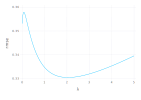

In [25]:
plot(df, x=:λ, y=:rmse, Geom.line)

In [26]:
λ̂ = df.λ[argmin(df.rmse)]

2.044

### (b) Comparer les estimations ridges avec vos estimations obtenues à l'exercice précédent.

Par exemple : Quelles variables sont les plus importantes ? Est-ce que les effets des variables changent ? Si oui, pourquoi ? Etc.

In [27]:
longdf = melt(df, [:λ, :rmse]) 
rename!(longdf, :variable=>:Parameter, :value=>:Estimation)
first(longdf, 5)

,λ,rmse,Parameter,Estimation
,Float64,Float64,Cat…,Float64
1,0.0,0.353107,β₁,0.858176
2,0.001,0.353302,β₁,0.85796
3,0.002,0.353484,β₁,0.857741
4,0.003,0.353657,β₁,0.857516
5,0.004,0.353823,β₁,0.857284


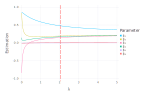

In [28]:
plot(longdf, x=:λ, y=:Estimation, color=:Parameter, Geom.line,
    xintercept=[λ̂], Geom.vline(style=:dash, color="red"))

On remarque que le poids demeure toujours la variable la plus importante relative la valeur des diamants. Les coefficients correspondants aux variables de dimensions (x,y,z) des diamants changent le plus. Certains coefficients changent même de signe. Cela est dû par le fait que la relation qui unit les variables explicatives à la valeur du diamant n'est pas unique. En ajoutant une loi *a priori* centrée en 0 pour les coefficient de régression, cela a pour effet d'ajouter une contrainte à la solution : on cherche la relation avec les près de 0 possible. Le poids de cette contrainte est contrôlé par λ.

### (c) Calculez un intervalle de crédibilité à 95 % pour le coefficient de régression associé au poids.

In [29]:
β̂ = (X'X + λ̂*I)\X'y
s² = (y'y - β̂'*(X'X + λ̂*I)*β̂)/n

0.017468916136371783

Intervalle de crédibilité = [0.3486792516327545, 0.6032613071198459]


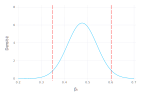

In [30]:
Σ = inv(X'X + λ̂*I)
pd = LocationScale(β̂[1], sqrt(s²*Σ[1,1]), TDist(n-m))

α = 0.05

println("Intervalle de crédibilité = ", quantile.(pd, [α/2 , 1-α/2]))

plot(x->pdf(pd,x), .2, .7,
    xintercept = quantile.(pd, [α/2 , 1-α/2]), Geom.vline(style=:dash,color="red"),
    Guide.xlabel("β₁"), Guide.ylabel("Densité"))

### (d) Déterminez si la profondeur possède une influence significative sur la valeur des diamants.

Intervalle de crédibilité = [-0.037461149278669455, 0.03276056573612104]


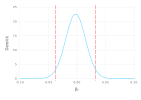

In [31]:
Σ = inv(X'X + λ̂*I)
pd = LocationScale(β̂[5], sqrt(s²*Σ[5,5]), TDist(n-m))

α = 0.05

println("Intervalle de crédibilité = ", quantile.(pd, [α/2 , 1-α/2]))

plot(x->pdf(pd,x), -.1, .1,
    xintercept = quantile.(pd, [α/2 , 1-α/2]), Geom.vline(style=:dash,color="red"),
    Guide.xlabel("β₅"), Guide.ylabel("Densité"))

Puisque la valeur 0 est incluse dans l'intervalle de crédibilité, on peut conclure que la profondeur n'est pas significative. En corrigeant pour la muticolinéarité, l'intervalle est moins large mais 0 est toujours une valeur plausible.